# Denoising And Extracting Time-Series

In [2]:
import sys
from src.data import subjects
print('Denoising waiting list:\n',subjects.to_denoise)
if subjects.to_denoise == []:
    sys.exit("There is no subject to be denoised!")
sub = subjects.to_denoise[0]
ses = 1
print('Currently processing: subject %s'%sub)

Denoising waiting list:
 ['011S4893']
Currently processing: subject 011S4893


In [3]:
#sub = '130S4990' # Subject ID
#ses = 1          # Session Number 

### Import data

In [4]:
%matplotlib inline
#%matplotlib notebook
from config import *
import src.denoising_timeseries.denoising_timeseries as dts
import os,sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nilearn.plotting
import nilearn.datasets
import nilearn.signal
import nibabel
import sklearn.preprocessing
import pkg_resources

#DATA_PATH = pkg_resources.resource_filename('brainnetworks', 'data/')                                        

subdir=subjects.preprocesseddir + '/sub-%s'%sub
assert os.path.exists(subdir)

sesdir=os.path.join(subdir,'ses-%d/func'%ses)

# get freesurfer data if we don't already have it
fsaverage = nilearn.datasets.fetch_surf_fsaverage(mesh='fsaverage5')

We will start by loading the data that were processed using [fMRIPrep](http://fmriprep.org) for a single session.  This preprocessing include:

- motion correction
- spatial distortion correction
- spatial normalization to the MNI volume template and the FreeSurfer fsaverage5 template

We are going to use the data on the surface because we can then easily sample the data into the Glasser et al. MMP parcellation.



In [5]:
# number of timepoints
ld1 = os.path.join(sesdir,'sub-%s_ses-%d_task-rest_space-fsaverage5_hemi-%s.func.gii'%(sub,ses,'L'))
ld2 = os.path.join(sesdir,'sub-%s_ses-%d_task-rest_space-fsaverage5_hemi-%s_bold.func.gii'%(sub,ses,'L'))

try: 
    ntp=len(nibabel.load(ld1).darrays)
except FileNotFoundError:
    ntp=len(nibabel.load(ld2).darrays)

# load the preprocessed fMRI data

hemispheres=['L','R']
bold_origfile={}
nverts=10242  # number of vertices in fsaverage5 per hemisphere
bolddata_orig=np.zeros((ntp,nverts*2))
for i,h in enumerate(hemispheres):
    
    try:
        bold_origfile[h]=os.path.join(sesdir,'sub-%s_ses-%d_task-rest_space-fsaverage5_hemi-%s.func.gii'%(sub,ses,h))
        d=nibabel.load(bold_origfile[h]).darrays
    except FileNotFoundError:
        bold_origfile[h]=os.path.join(sesdir,'sub-%s_ses-%d_task-rest_space-fsaverage5_hemi-%s_bold.func.gii'%(sub,ses,h))
        d=nibabel.load(bold_origfile[h]).darrays
    for tp in range(len(d)):
        bolddata_orig[tp,(i*nverts):((i+1)*nverts)]=d[tp].data

print('data shape:',bolddata_orig.shape)

data shape: (197, 20484)


In [6]:
bolddata_orig.shape

(197, 20484)

### Confound regression

One of the common procedures applied to resting fMRI data is to regress out potential confounding variables. These include variables related to motion estimates and their temporal derivatives, as well as variables related to other signal components that are thought to be artifactual.  These can include:

- CSF signal
- white matter signal
- DVARS: a measure of changes in the global brain signal
- aCompCor: low-dimensional components within regions defined as non-GM (i.e. CSF and white matter)
- tCompCor: low-dimensional components within regions defined by having high temporal variability
- low frequency signals (usually below about .08 Hz)

These confounds are computed by fMRIprep and saved to a file alongside the data, which we load here.

confound variables: Index(['csf', 'csf_derivative1', 'csf_derivative1_power2', 'csf_power2',
       'white_matter', 'white_matter_derivative1', 'white_matter_power2',
       'white_matter_derivative1_power2', 'global_signal',
       'global_signal_derivative1',
       ...
       'aroma_motion_33', 'aroma_motion_34', 'aroma_motion_35',
       'aroma_motion_36', 'aroma_motion_37', 'aroma_motion_38',
       'aroma_motion_42', 'aroma_motion_44', 'aroma_motion_45',
       'aroma_motion_47'],
      dtype='object', length=212)


/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


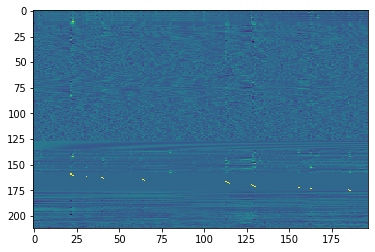

In [7]:
# load the confound data

confounds=pd.read_csv(os.path.join(sesdir,
                        'sub-%s_ses-%d_task-rest_desc-confounds_regressors.tsv'%(sub,ses)),
                         sep='\t',na_values='n/a')
confounds=confounds.replace(np.nan,0)

# add temporal derivatives of motion estimates
# motionvars=['X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']
# estimated head-motion parameters:
motionvars=['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']

for v in motionvars:
    confounds['%s_derivative1'%v]=0
    confounds['%s_derivative1'%v].iloc[1:]=confounds[v].iloc[1:].values - confounds[v].iloc[:-1].values

print('confound variables:',confounds.columns)

plt.imshow(sklearn.preprocessing.scale(confounds).T,aspect='auto',
           cmap='viridis',interpolation='nearest')

In [8]:
#list(confounds.iloc[0].keys())
#confounds.framewise_displacement
#confounds.trans_x_derivative1
#confounds[['cosine04','cosine00']]

Let's plot the data across all surface vertices next a measure of motion (Framewise Displacement).  This shows that motion tends to induce fairly large global signal changes, which persist even after motion correction.

(0.0, 197.0, 0.0, 1.0)

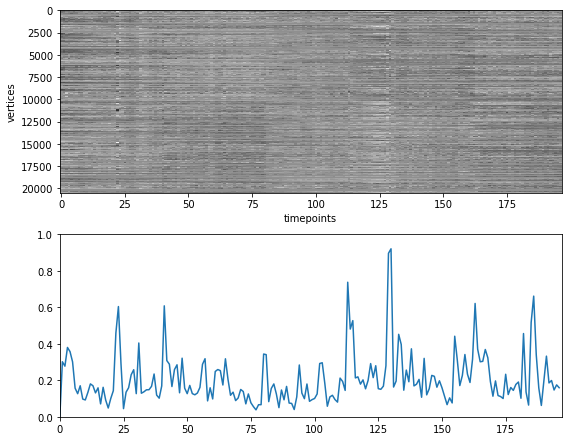

In [9]:
plt.figure(figsize=(8,6))

plt.subplot(2,1,1)
plt.imshow(sklearn.preprocessing.scale(bolddata_orig).T,aspect='auto',
           cmap='gray',interpolation='nearest')
plt.xlabel('timepoints')
plt.ylabel('vertices')
plt.tight_layout()

plt.subplot(2,1,2)

plt.plot(confounds.framewise_displacement)
plt.axis([0,bolddata_orig.shape[0],0,1])

### Overview of confound regression strategies

Models 1–5 used nuisance parameters derived from 6 movement estimates and 3 physiological time series, as well as their temporal derivatives and quadratic expansions.
* Model 1. (2P) Used only the 2 physiological time series: mean signal in WM and mean signal in CSF, and functioned as a base model for comparison to other more complex confound regression models.
* Model 2. (6P) Used only the 6 motion estimates derived from mcflirt realignment as explanatory variables.
* Model 3. (9P) Combined the 6 motion estimates and 2 physiological time series with global signal regression. This model has been widely applied to functional connectivity studies (Fox et al., 2005, 2009).
* Model 4. (24P) Expansion of model 2 that includes 6 motion parameters, 6 temporal derivatives, 6 quadratic terms, and 6 quadratic expansions of the derivatives of motion estimates for a total 24 regressors (Friston et al., 1996). 
* Model 5. (36P) Similar expansion of model 3: 9 regressors, their derivatives, quadratic terms, and squares of derivatives (Satterthwaite et al., 2013). 


Models 6–8 further expanded upon this maximal 36P strategy by incorporating censoring approaches. 
* Model 6. (36P+despike) Included 36 regressors as well as despiking (Cox, 1996).
* Model 7. (36P+spkreg) Included 36 regressors as well as spike regression, as in Satterthwaite et al. (2013). 
* Model 8. (36P+scrub) Included 36 regressors as well as motion scrubbing, as in Power et al. (2014a). 


Models 9 and 10 adapted variants of the PCA-based CompCor approach. 
* Model 9. (aCompCor) Used 5 principal components each from the WM and CSF, in addition to motion estimates and their temporal derivatives (Muschelli et al., 2014). 
* Model 10. (tCompCor) Used 6 principal compo- nents from high-variance voxels (Behzadi et al., 2007). Models 11 and 12 comparatively evaluated the efficacy of local and global-mean tissue-class regressors. 
* Model 11. (wmLocal) Used a voxelwise, localised WM regressor in addition to motion estimates and their temporal derivatives and despiking (Jo et al., 2013). 
* Model 12. (wmMean) Identical to model 11 except that it used the mean signal across the WM instead of a voxelwise, localised WM regressor (Jo et al., 2013). 

Models 13 and 14 evaluated subject-specific ICA denoising. 
* Model 13. (ICA-AROMA) Used a recently devel- oped ICA-based procedure for removal of motion- related variance from BOLD data, together with mean WM and CSF regressors (Pruim et al., 2015a,b). 
* Model 14. (AROMA+GSR) Combined ICA- AROMA as implemented in model 13 with global sig- nal regression, in a procedure somewhat analogous to Burgess et al. (2016).

Here we are going to implement model 3(9P), model 5(36P) and model 8(36P+scrub).

#### Drop Dummy TRs 

In [10]:
#First we'll load in our data and check the shape
bolddata = bolddata_orig
try:
    a = confounds['non_steady_state_outlier00'].index[confounds['non_steady_state_outlier00'] == 1].tolist()[0]
    bolddata = bolddata_orig[a+1:,:]
    confounds = confounds.loc[a+1:]
except:    
    pass
ntp = confounds.shape[0]

In [11]:
#Creatin Confounds tables:
confounds9p = ['csf', 'white_matter', 'global_signal','trans_x', 'trans_y', 'trans_z',
               'rot_x', 'rot_y', 'rot_z',]
confounds36p = confounds9p + ['csf_derivative1', 'csf_derivative1_power2', 'csf_power2',
                                'white_matter_derivative1', 'white_matter_derivative1_power2', 'white_matter_power2',
                                'global_signal_derivative1', 'global_signal_derivative1_power2', 'global_signal_power2',
                                'trans_x_derivative1', 'trans_x_derivative1_power2', 'trans_x_power2',
                                'trans_y_derivative1', 'trans_y_derivative1_power2', 'trans_y_power2',
                                'trans_z_derivative1', 'trans_z_derivative1_power2', 'trans_z_power2',
                                'rot_x_derivative1', 'rot_x_derivative1_power2', 'rot_x_power2',
                                'rot_y_derivative1', 'rot_y_derivative1_power2', 'rot_y_power2',
                                'rot_z_derivative1', 'rot_z_derivative1_power2', 'rot_z_power2',
                              ]
confounds9p = confounds[confounds9p]
confounds36p = confounds[confounds36p]

In [12]:
#First create a matrix of zeroes that matches our signals matrix
bolddata9p = np.zeros_like(bolddata)
bolddata36p = np.zeros_like(bolddata)

#Apply only to brain voxels
bolddata9p = nilearn.signal.clean(bolddata, confounds=confounds9p.values)
bolddata36p = nilearn.signal.clean(bolddata, confounds=confounds36p.values)

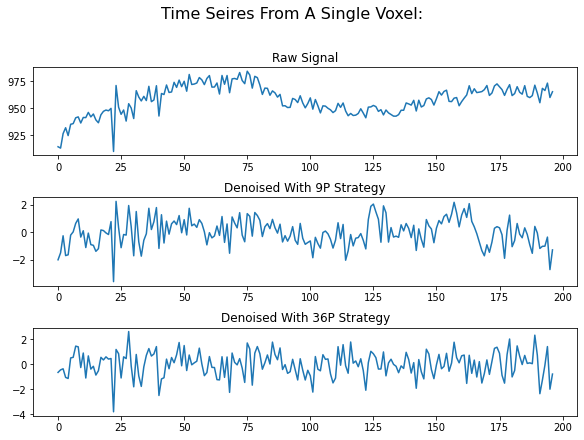

In [13]:
fig, axs = plt.subplots(3, 1, constrained_layout=True,figsize=(8,6))
axs[0].plot(bolddata[:,1010])
axs[0].set_title('Raw Signal')
fig.suptitle("Time Seires From A Single Voxel:\n", fontsize=16)

axs[1].plot(bolddata9p[:,1010])
axs[1].set_title('Denoised With 9P Strategy')

axs[2].plot(bolddata36p[:,1010])
axs[2].set_title('Denoised With 36P Strategy')

plt.show()

# Extracting data from parcellation

In general we don't work with the data from each voxel/vertex, because (as we will discuss in more detail later in the course) there seems to be clear low-dimensional structure in the data.  Instead, we usually average over a smaller number of *parcels* that we think are related to one another.  For the present analysis we will use a group parcellation generated by Glasser et al. from the Human Connectome Project data. Let's extract the signal for all of the parcels from our data.

In [14]:
atlasdir=rootdir + '/references/HCP-MMP1'
atlas={'L':'lh.HCP-MMP1.fsaverage5.gii','R':'rh.HCP-MMP1.fsaverage5.gii'}
atlasdata={}
atlaslabels={}
for a in atlas:
   atlaslabeltable=nibabel.load(os.path.join(atlasdir,atlas[a])).labeltable.labels
   atlaslabels[a]=[i.label for i in atlaslabeltable[1:]]
   atlasdata[a]=nibabel.load(os.path.join(atlasdir,atlas[a])).darrays[0].data 
allatlaslabels=atlaslabels['L']+atlaslabels['R']
allatlasdata=np.hstack((atlasdata['L'],atlasdata['R']+180))  

<Figure size 576x576 with 0 Axes>

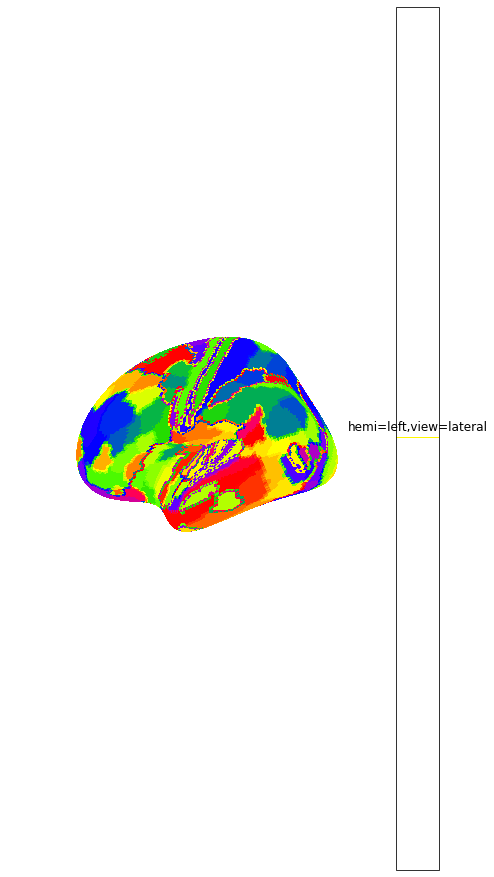

<Figure size 576x576 with 0 Axes>

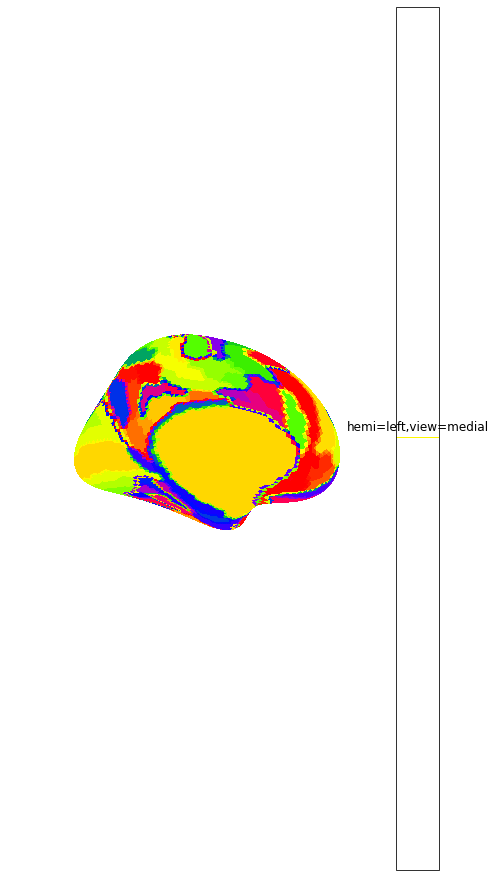

<Figure size 576x576 with 0 Axes>

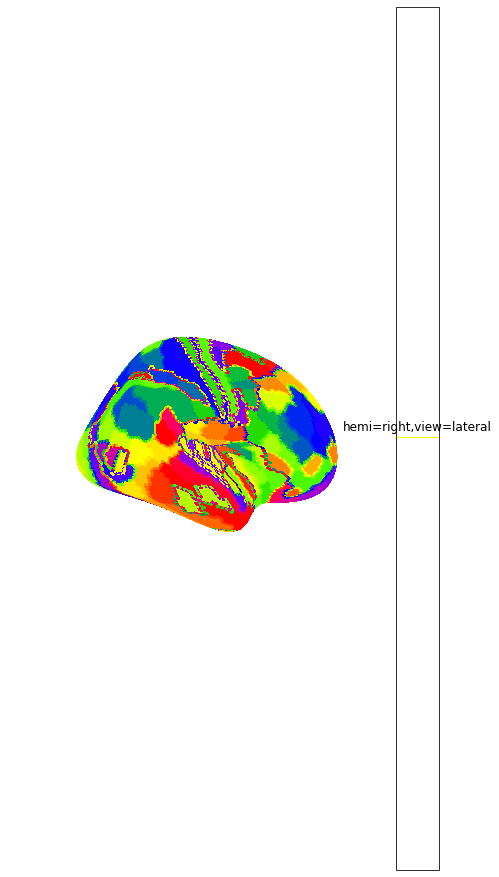

<Figure size 576x576 with 0 Axes>

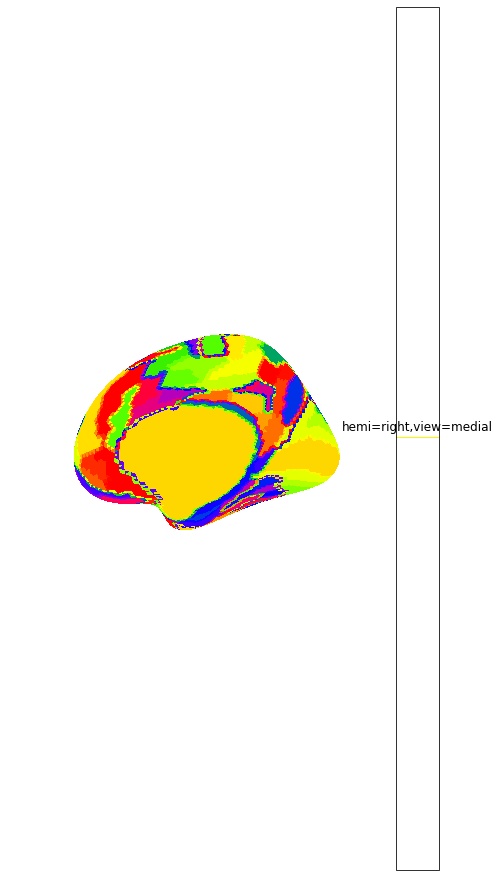

In [15]:
# plot each hemisphere/view

for i,hemi in enumerate(['left','right']):
    for view in ['lateral','medial']:
        plt.figure(figsize=(8,8))
        nilearn.plotting.plot_surf_stat_map(fsaverage['infl_%s'%hemi], 
                                    atlasdata[hemispheres[i]],
                                    thresh=0.5,
                                    hemi=hemi,
                                    view=view,cmap='prism',darkness=.5)
        plt.title('hemi=%s,view=%s'%(hemi,view))

Let's extract the mean timeseries from each of the parcels.

In [16]:
roidata    = np.zeros((ntp,361))
roidata9p  = np.zeros((ntp,361))
roidata36p = np.zeros((ntp,361))

for region in range(361):
    if region == 0:
        continue
    regionverts = allatlasdata == region
    for tp in range(ntp):
      tmp = bolddata[tp,:]
      roidata[tp,region] = np.mean(tmp[regionverts])
      tmp = bolddata9p[tp,:]
      roidata9p[tp,region] = np.mean(tmp[regionverts])
      tmp = bolddata36p[tp,:]
      roidata36p[tp,region] = np.mean(tmp[regionverts])

### Motion scrubbing

In general, the effects of motion will persist even after the use of confound regression. For this reason, many investigators will censor (or *scrub*) the data by removing timepoints that exceed some particular threshold for motion, along with a number of following timepoints (since the effects of motion often persist for several timepoints).  

One common strategy is to identify timepoints that exceed a particular FD threshold (an aggressive choice advocated by Power and colleagues is FD>0.2; a less aggressive threshold commonly used is 0.5) along with some number of timepoints that follow those (with 10 being an aggressive number).  Note that scrubbing will interfere with analyses that require the full timeseries, but for simple correlations it doesn't cause any problems. Let's generate the temporal mask to identify and remove bad timeseries - we will use a less aggressive threshold but an aggressive window for removal of timepoints following motion.

In [17]:
fd_thresh=0.5
tps_exceeding_fd_thresh=np.where(confounds.framewise_displacement.values>fd_thresh)
tswindow=10
tsmask=np.ones(confounds.shape[0])
for tp in tps_exceeding_fd_thresh[0]:
    tsmask[(tp-1):(tp+tswindow)]=0

print('%d good timepoints remaining after scrubbing (%d removed)'%(np.sum(tsmask),
                                                                   ntp - np.sum(tsmask)))

127 good timepoints remaining after scrubbing (70 removed)


Now we censor the masked timepoints

In [18]:
roidata36p_scrubbed=roidata36p[np.where(tsmask)[0],:]

Let's look at the data from one parcel (in the left posterior cingulate cortex):

using region 30: L_POS1_ROI


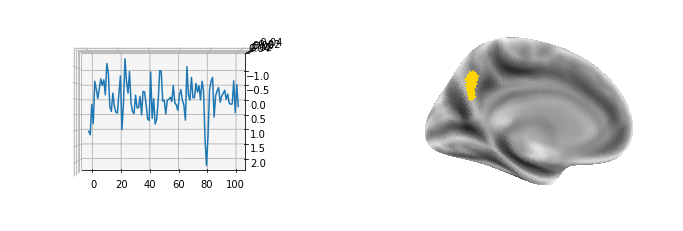

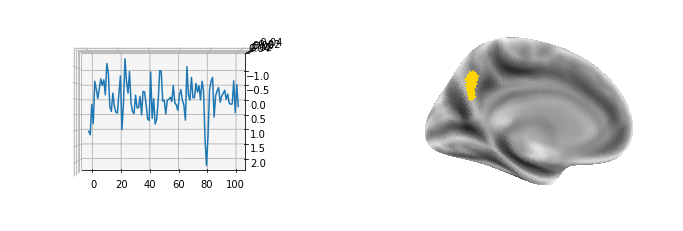

In [19]:
parcelnum=30
print('using region %d: %s'%(parcelnum,atlaslabels['L'][parcelnum]))

f,ax=plt.subplots(1,2,subplot_kw={"projection": "3d"},figsize=(12,4))
ax[0].view_init(270,270)
ntp_to_plot=100
ax[0].plot(range(ntp_to_plot),roidata36p[:ntp_to_plot,parcelnum],zs=0)
nilearn.plotting.plot_surf_roi(fsaverage['infl_left'], 
                                    (atlasdata['L']==parcelnum).astype('int'),thresh=0.5,
                                    hemi='left',bg_map=fsaverage['sulc_left'],
                                   view='medial',cmap='prism',axes=ax[1])


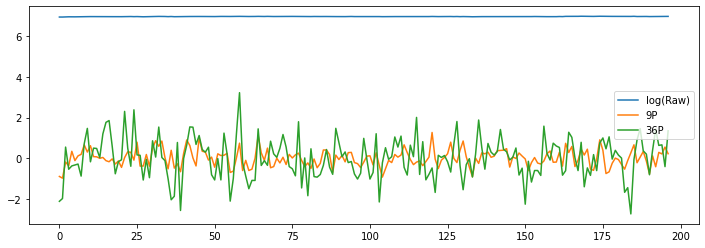

In [20]:
plt.figure(figsize=(12,4))
parcelnum=12
plt.plot(np.log(roidata[:,parcelnum]),label='log(Raw)')
plt.plot(roidata9p[:,parcelnum],label='9P')
plt.plot(bolddata36p[:,parcelnum],label='36P')

plt.legend()

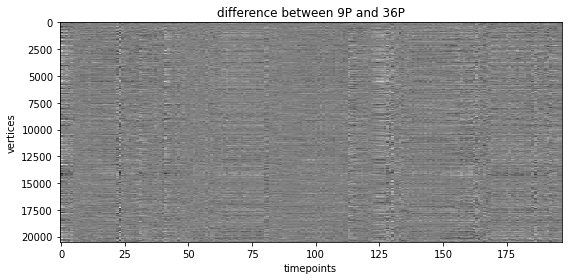

In [21]:
plt.figure(figsize=(8,4))
plt.imshow(bolddata9p.T-bolddata36p.T,
           aspect='auto',cmap='gray',
          interpolation='nearest')
plt.xlabel('timepoints')
plt.ylabel('vertices')
plt.title('difference between 9P and 36P')
plt.tight_layout()

### Save Data

In [22]:
os.system('mkdir -p %s/data/03_time_series/ds-9p %s/data/03_time_series/ds-36p \
%s/data/03_time_series/ds-36pscrubbed %s/data/03_time_series/ds-raw'
          %(rootdir,rootdir,rootdir,rootdir))

np.save("%s/data/03_time_series/ds-9p/sub-%s_ds-9p"
        %(rootdir, sub), roidata9p)
np.save("%s/data/03_time_series/ds-36p/sub-%s_ds-36p"
        %(rootdir, sub), roidata36p)
np.save("%s/data/03_time_series/ds-36pscrubbed/sub-%s_ds-36pscrubbed"
        %(rootdir, sub), roidata36p_scrubbed)
np.save("%s/data/03_time_series/ds-raw/sub-%s_ds-raw"
        %(rootdir, sub), roidata)

In [23]:
%%javascript
Jupyter.notebook.save_checkpoint()

<IPython.core.display.Javascript object>

In [24]:
%%javascript
Jupyter.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [25]:
#os.system("cp /home/alireza/Thesis/Databases/ADNI/connectivity_derivs/codes/Pipeline/03_denoising_and_extracting_time-Series.ipynb /home/alireza/Thesis/Databases/ADNI/connectivity_derivs/codes/Denoising/sub-%s_denoising.ipynb"%(sub))

### Denoise every subjects

In [26]:
dts.denoise_all(subjects.to_denoise)

processing sub-011S4893
data shape: (197, 20484)


/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


127 good timepoints remaining after scrubbing (70 removed)


processing sub-002S4473
data shape: (140, 20484)
100 good timepoints remaining after scrubbing (39 removed)
processing sub-012S4188
data shape: (140, 20484)
115 good timepoints remaining after scrubbing (24 removed)
processing sub-137S4299
data shape: (197, 20484)
197 good timepoints remaining after scrubbing (0 removed)
processing sub-037S4706
data shape: (197, 20484)
197 good timepoints remaining after scrubbing (0 removed)
processing sub-011S4547
data shape: (197, 20484)
90 good timepoints remaining after scrubbing (107 removed)
processing sub-041S4513
data shape: (197, 20484)
135 good timepoints remaining after scrubbing (62 removed)
processing sub-137S4351
data shape: (197, 20484)
32 good timepoints remaining after scrubbing (165 removed)
processing sub-068S2315
data shape: (197, 20484)
176 good timepoints remaining after scrubbing (21 removed)
processing sub-041S4974
data shape: (197, 20484)
121 good timepoints remaining after scrubbing (76 removed)
processing sub-094S2201
data shape: (197, 20484)
181 good timepoints remaining after scrubbing (16 removed)
processing sub-012S4987
data shape: (140, 20484)
91 good timepoints remaining after scrubbing (48 removed)
processing sub-068S4431
data shape: (197, 20484)
186 good timepoints remaining after scrubbing (11 removed)
processing sub-068S2184
data shape: (197, 20484)
79 good timepoints remaining after scrubbing (118 removed)
processing sub-082S2121
data shape: (197, 20484)
197 good timepoints remaining after scrubbing (0 removed)
processing sub-137S4536
data shape: (197, 20484)
185 good timepoints remaining after scrubbing (12 removed)
processing sub-006S4363
data shape: (140, 20484)
45 good timepoints remaining after scrubbing (94 removed)
processing sub-006S4713
data shape: (140, 20484)
128 good timepoints remaining after scrubbing (11 removed)
processing sub-068S4061
data shape: (197, 20484)
159 good timepoints remaining after scrubbing (38 removed)
processing sub-002S4746
data shape: (140, 20484)
125 good timepoints remaining after scrubbing (14 removed)
processing sub-002S4654
data shape: (140, 20484)
139 good timepoints remaining after scrubbing (0 removed)
processing sub-941S4187
data shape: (197, 20484)
175 good timepoints remaining after scrubbing (22 removed)
processing sub-006S4346
data shape: (140, 20484)
97 good timepoints remaining after scrubbing (42 removed)
processing sub-037S4030
data shape: (197, 20484)
49 good timepoints remaining after scrubbing (148 removed)
processing sub-037S4214
data shape: (197, 20484)
120 good timepoints remaining after scrubbing (77 removed)
processing sub-036S4430
data shape: (197, 20484)
4 good timepoints remaining after scrubbing (192 removed)
processing sub-036S4538
data shape: (197, 20484)
67 good timepoints remaining after scrubbing (130 removed)
processing sub-035S4414
data shape: (197, 20484)
139 good timepoints remaining after scrubbing (58 removed)
processing sub-002S4251
data shape: (140, 20484)
139 good timepoints remaining after scrubbing (0 removed)
processing sub-019S4252
data shape: (140, 20484)
27 good timepoints remaining after scrubbing (112 removed)
processing sub-013S5071
data shape: (140, 20484)
102 good timepoints remaining after scrubbing (37 removed)
processing sub-168S6085
data shape: (197, 20484)
186 good timepoints remaining after scrubbing (11 removed)
processing sub-031S4032
data shape: (140, 20484)
116 good timepoints remaining after scrubbing (23 removed)
processing sub-019S5012
data shape: (140, 20484)
139 good timepoints remaining after scrubbing (0 removed)
processing sub-002S4229
data shape: (140, 20484)
128 good timepoints remaining after scrubbing (11 removed)
processing sub-130S4660
data shape: (140, 20484)
52 good timepoints remaining after scrubbing (87 removed)
processing sub-002S4219
data shape: (140, 20484)
21 good timepoints remaining after scrubbing (118 removed)
processing sub-941S6094
data shape: (197, 20484)
167 good timepoints remaining after scrubbing (30 removed)
processing sub-136S4993
data shape: (140, 20484)
55 good timepoints remaining after scrubbing (84 removed)
processing sub-168S6131
data shape: (197, 20484)
197 good timepoints remaining after scrubbing (0 removed)
processing sub-041S6192
data shape: (197, 20484)
186 good timepoints remaining after scrubbing (11 removed)
processing sub-094S4649
data shape: (197, 20484)
21 good timepoints remaining after scrubbing (176 removed)
processing sub-053S5070
data shape: (140, 20484)
106 good timepoints remaining after scrubbing (33 removed)
processing sub-018S4313
data shape: (140, 20484)
87 good timepoints remaining after scrubbing (52 removed)
processing sub-114S6063
data shape: (197, 20484)
164 good timepoints remaining after scrubbing (33 removed)
processing sub-006S4867
data shape: (140, 20484)
135 good timepoints remaining after scrubbing (4 removed)
processing sub-116S6119
data shape: (197, 20484)
197 good timepoints remaining after scrubbing (0 removed)
processing sub-114S0416
data shape: (197, 20484)
186 good timepoints remaining after scrubbing (11 removed)
processing sub-011S0021
data shape: (197, 20484)
146 good timepoints remaining after scrubbing (51 removed)
processing sub-002S5018
data shape: (140, 20484)
91 good timepoints remaining after scrubbing (48 removed)
processing sub-033S4176
data shape: (200, 20484)
187 good timepoints remaining after scrubbing (12 removed)
processing sub-130S4589
data shape: (140, 20484)
128 good timepoints remaining after scrubbing (11 removed)
processing sub-036S6189
data shape: (197, 20484)
66 good timepoints remaining after scrubbing (131 removed)
processing sub-041S4510
data shape: (197, 20484)
197 good timepoints remaining after scrubbing (0 removed)
processing sub-023S1190
data shape: (197, 20484)
36 good timepoints remaining after scrubbing (161 removed)
processing sub-018S4733
data shape: (140, 20484)
32 good timepoints remaining after scrubbing (107 removed)
processing sub-130S4971
data shape: (140, 20484)
66 good timepoints remaining after scrubbing (73 removed)
processing sub-130S4984
data shape: (140, 20484)
139 good timepoints remaining after scrubbing (0 removed)
processing sub-130S5059
data shape: (140, 20484)
38 good timepoints remaining after scrubbing (101 removed)
processing sub-019S4549
data shape: (140, 20484)
117 good timepoints remaining after scrubbing (22 removed)
processing sub-037S4028
data shape: (197, 20484)
171 good timepoints remaining after scrubbing (26 removed)
processing sub-100S5106
data shape: (140, 20484)
139 good timepoints remaining after scrubbing (0 removed)
processing sub-041S6159
data shape: (197, 20484)
160 good timepoints remaining after scrubbing (37 removed)
processing sub-002S4262
data shape: (140, 20484)
128 good timepoints remaining after scrubbing (11 removed)
processing sub-116S4453
data shape: (197, 20484)
175 good timepoints remaining after scrubbing (22 removed)
processing sub-130S5231
data shape: (140, 20484)
6 good timepoints remaining after scrubbing (133 removed)
processing sub-035S6160
data shape: (197, 20484)
53 good timepoints remaining after scrubbing (144 removed)
processing sub-168S6098
data shape: (197, 20484)
190 good timepoints remaining after scrubbing (7 removed)
processing sub-003S4354
data shape: (197, 20484)
25 good timepoints remaining after scrubbing (172 removed)
processing sub-053S5208
data shape: (140, 20484)
35 good timepoints remaining after scrubbing (104 removed)
processing sub-002S4225
data shape: (140, 20484)
50 good timepoints remaining after scrubbing (89 removed)
processing sub-013S4395
data shape: (140, 20484)
100 good timepoints remaining after scrubbing (39 removed)
processing sub-020S6185
data shape: (197, 20484)
186 good timepoints remaining after scrubbing (11 removed)
processing sub-019S4477
data shape: (140, 20484)
66 good timepoints remaining after scrubbing (73 removed)
processing sub-003S4288
data shape: (197, 20484)
74 good timepoints remaining after scrubbing (123 removed)
processing sub-130S4641
data shape: (140, 20484)
34 good timepoints remaining after scrubbing (105 removed)
processing sub-018S5074
data shape: (140, 20484)
56 good timepoints remaining after scrubbing (83 removed)
processing sub-018S4696
data shape: (140, 20484)
30 good timepoints remaining after scrubbing (109 removed)
processing sub-006S4153
data shape: (140, 20484)
112 good timepoints remaining after scrubbing (27 removed)
processing sub-006S4515
data shape: (140, 20484)
48 good timepoints remaining after scrubbing (91 removed)
processing sub-002S4171
data shape: (140, 20484)
67 good timepoints remaining after scrubbing (72 removed)
processing sub-013S4236
data shape: (140, 20484)
139 good timepoints remaining after scrubbing (0 removed)
processing sub-006S4960
data shape: (140, 20484)
108 good timepoints remaining after scrubbing (31 removed)
processing sub-130S4730
data shape: (140, 20484)
27 good timepoints remaining after scrubbing (112 removed)
processing sub-036S4715
data shape: (197, 20484)
165 good timepoints remaining after scrubbing (32 removed)